/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_16331/937372415.py:32: RuntimeWarning: divide by zero encountered in log10
  plt.imshow(np.log10(D.img), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)


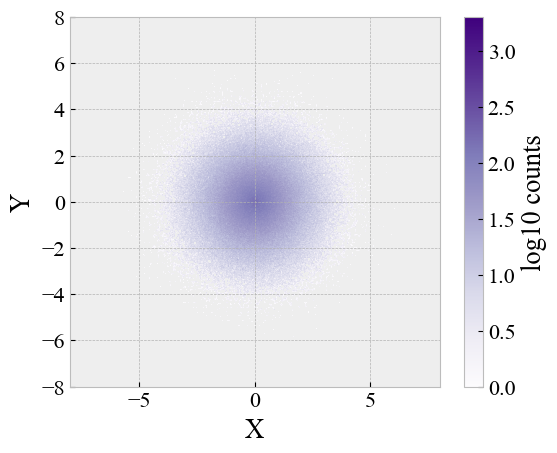

/var/folders/hk/kt8z304n2n11x6tfqk2bmsmw0000gp/T/ipykernel_16331/937372415.py:46: RuntimeWarning: invalid value encountered in log10
  plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)


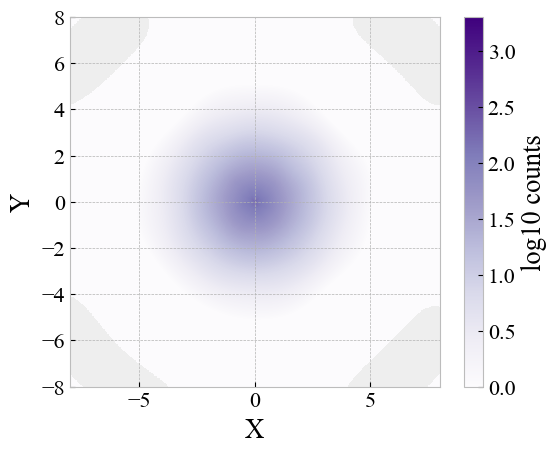

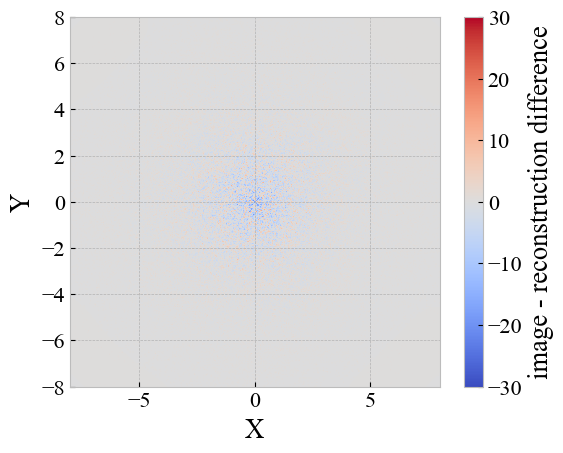

[[ 1.55228474e+02 -2.48621479e-01 -1.85092142e-01 -8.72524485e-02
  -8.98895993e-02  3.28424990e-02 -2.28349913e-02 -1.21737033e-03
   9.87289413e-02  1.54808683e-01]
 [ 6.60207166e-01  1.45067731e-01  4.03383096e-02  4.48602576e-02
   8.41977650e-02  1.35714761e-01  1.37934361e-01  1.11100608e-01
   9.19101816e-02  8.37548535e-02]
 [ 5.29217968e-02 -4.77463122e-02  1.31479231e-02  2.15689333e-01
   3.43878601e-01  3.39123903e-01  2.61509503e-01  1.66746926e-01
   8.13047739e-02  1.35208181e-02]
 [-1.35455582e-01 -1.54996038e-01 -3.67738938e-01 -4.58061298e-01
  -3.84779088e-01 -2.53851393e-01 -1.90454537e-01 -2.19865260e-01
  -2.68569473e-01 -2.62503885e-01]
 [-3.98759482e-01 -1.02432678e+00 -1.10454488e+00 -1.13274236e+00
  -1.25811672e+00 -1.25481426e+00 -1.42391957e+00 -1.60503830e+00
  -1.69983476e+00 -1.78045855e+00]
 [-4.86318587e-01 -6.51215377e-01 -3.51482647e-01 -6.06096536e-02
   1.48874469e-01  2.28655239e-01  2.12693682e-01  1.52274412e-01
   9.26528746e-02  5.76426764e-02

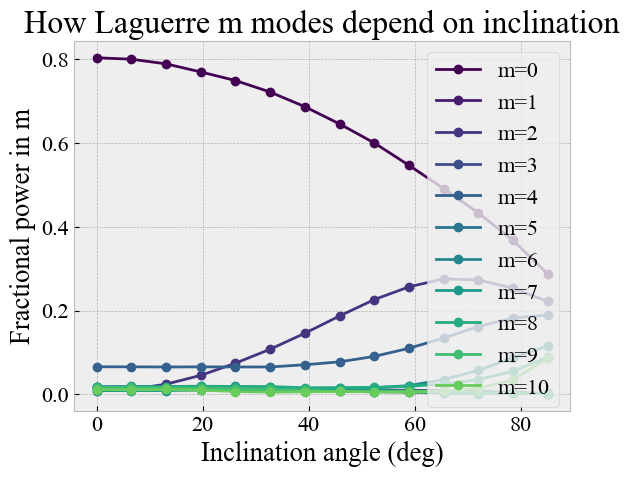

In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import h5py


plt.rcParams.update({'font.size': 16})
plt.rcParams["font.family"] = "Times New Roman"
plt.style.use('bmh')

# if DiscModel is in a different file
from DiscModel import DiscGalaxy

N = 1000000 # number of stars in the disc
# a is the scale length of the disc in kpc
a = 1.0
D = DiscGalaxy(N=N,a=a)

inclinationvalue = 0 # no inclination to start (face-on) , in degrees
D.rotate_disc(inclinationvalue,0,0)

# this image is tough to expand (but more realistic)
D.generate_image(rmax=20.,nbins=64,noiselevel=0.)

# this image is easier to expand (but less realistic): a good starting point
D.generate_image(rmax=8.,nbins=512,noiselevel=0.)


E = D.make_expansion(10, 10, a)

# Plot the 2D histogram
plt.imshow(np.log10(D.img), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# make the FLEX expansion: mmax=10, nmax=10
# this is a good starting point, but you can increase or decrease mmax and nmax to see what happens
E1 = D.make_expansion(10,10,a,noisy=False)

# (re)construct an image from the expansion coefficients
E1.laguerre_reconstruction(D.r,D.p)


plt.imshow(np.log10(E1.reconstruction), origin='lower', cmap='Purples', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=0.,vmax=3.3)
plt.colorbar(label='log10 counts')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

plt.figure()
# why is there a 3%ish bias here?
plt.imshow(D.img - 1.03*E1.reconstruction, origin='lower', cmap='coolwarm', extent=[D.x_edges[0], D.x_edges[-1], D.y_edges[0], D.y_edges[-1]],vmin=-30.,vmax=30.)
plt.colorbar(label='image - reconstruction difference')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


with h5py.File("example_galaxy.hdf5", "a") as f:
    group = f.require_group("f444w/00001_expansion")
    
    # Remove datasets if they exist
    for dname in ["coscoefs", "sincoefs"]:
        if dname in group:
            del group[dname]
    
    # Now safely create
    group.create_dataset("coscoefs", data=E.coscoefs)
    group.create_dataset("sincoefs", data=E.sincoefs)
    group.attrs["inclination_angle_deg"] = inclinationvalue

print(E.coscoefs)
print(E.sincoefs)

import matplotlib.pyplot as plt
import numpy as np
from DiscModel import DiscGalaxy

# Parameters
N = 1_000_000
a = 1.0
rmax = 8.
nbins = 512
mmax = 10
nmax = 10

# Inclination angles to test
inclinations = [0, 30, 60, 85]

#prepare figure
#fig, axs = plt.subplots(2, len(inclinations), figsize=(4*len(inclinations), 8))

for idx, inc in enumerate(inclinations):
    # Generate galaxy
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    # Compute magnitude of coefficients
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    
    # Sum over m to get total power per m
    m_power = np.sum(coef_mag, axis=1)
    
    
    n_power = np.sum(coef_mag, axis=0)
    """
    # Plot
    axs[0, idx].bar(range(mmax+1), m_power)
    axs[0, idx].set_title(f"Inclination {inc}°: Power vs m")
    axs[0, idx].set_xlabel('m')
    axs[0, idx].set_ylabel('Total Power')
    
    axs[1, idx].bar(range(nmax), n_power)
    axs[1, idx].set_title(f"Inclination {inc}°: Power vs n")
    axs[1, idx].set_xlabel('n')
    axs[1, idx].set_ylabel('Total Power')
    """

#plt.tight_layout()
#plt.show()


N = 1_000_000
a = 1.0
rmax = 8.
nbins = 512
mmax = 10
nmax = 10
inclinations = np.linspace(0, 85, 14)  # Inclination angles from 0 to 85 degrees
colormap = plt.cm.viridis(np.linspace(0, 1, len(inclinations)))
# Store results
results = []

for inc in inclinations:
    D = DiscGalaxy(N=N, a=a)
    D.rotate_disc(inc, 0, 0)
    D.generate_image(rmax=rmax, nbins=nbins, noiselevel=0.)
    E = D.make_expansion(mmax, nmax, a)
    
    coef_mag = np.sqrt(E.coscoefs**2 + E.sincoefs**2)
    m_power = np.sum(coef_mag, axis=1)
    total_power = np.sum(m_power)
    frac_power = m_power / total_power
    
    results.append({
        "inclination": inc,
        "m_power": m_power,
        "frac_power": frac_power
    })

# Plot fractional power vs inclination for each m
for m in range(mmax+1):
    plt.plot([r["inclination"] for r in results],
             [r["frac_power"][m] for r in results],
             marker='o', label=f"m={m}", color=colormap[m])

plt.xlabel("Inclination angle (deg)")
plt.ylabel("Fractional power in m")
plt.legend()
plt.title("How Laguerre m modes depend on inclination")
plt.show()
